In [18]:
import numpy as np
import pandas as pd
import os
import multiprocessing
#import stuff and define functions
from typing import Dict, List, Optional, Union
from pathlib import Path
from sklearn.decomposition import IncrementalPCA, PCA
from CustomFunctions import shapePCAtools, file_management
import math
from vtk.util import numpy_support
import vtk
from aicsshparam import shtools
import pickle as pk

In [19]:
#directories for opening and saving pca stuff
basedir = 'E:/Aaron/Combined_37C_Confocal_PCA_rawtracks/'
savedir = basedir + 'Data_and_Figs/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

In [20]:
############# gather data from all experiments ###############
# get the datasets to be combined
datasets = [x for x in os.listdir(savedir) if 'Shape_Metrics' in x]
exlists = [x for x in os.listdir(savedir) if 'ListToExclude' in x]

#### open shape metrics and include bad SH cells
smlst = []
for d in range(len(datasets)):
    #open shape metrics
    sm = pd.read_csv(savedir + datasets[d], index_col = 0)
    #open the list of cells to exclude
    excludes = pd.read_csv(savedir + exlists[d], index_col=0)
    list_to_exclude = [i.replace('_segmented.tiff', '') for i in excludes.iloc[:,0].to_list()]
    sm = sm.loc[[x for x in sm.index if x not in list_to_exclude]]
    smlst.append(sm)
smdf = pd.concat(smlst)
    
    
#open all of the other metrics from the single csv files
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=60)
    csvlist = [basedir + 'processed_data/' + i +'_cell_info.csv' for i in smdf.cell.to_list()]
    celllist = pool.map(file_management.multicsv, csvlist)
    pool.close()
    pool.join()
cellinfo = pd.concat(celllist)


### make dataframes and merge    
df = smdf.merge(cellinfo.drop(columns=['image', 'cropx (pixels)',
       'cropy (pixels)', 'cropz (pixels)']), left_on = 'cell', right_on = 'cell')

In [21]:
########### FILTER THE DATA A BIT ###############
print(len(df))

############# filter out shape outliers #############
df = df[(df.Cell_Volume < 2070) & (df.Cell_Volume > 498)]
df = df[(df.Cell_SurfaceArea < 1800) & (df.Cell_SurfaceArea > 500)]
print(len(df))

############## filter out speed outliers #############
df = df.drop(df[df.isin(df[df.speed>0.8].CellID.unique()).any(axis=1)].index).reset_index(drop=True)
print(len(df))

############# filter out galvanotaxis ##############
df = df.drop(df[(df.CellID.isin([x for x in df.CellID.unique() if '3mA' in x])) & (df.frame>180)].index).reset_index(drop=True)
print(len(df))

167352
158790
145017
131296


In [22]:
######### PERFORM PCA ################

#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
lmax = 10


#get coeffs only
coeff_df = df[[x for x in df.columns.to_list() if 'shcoeffs' in x]]


# Fit and transform the data
pca = PCA(n_components=npcs)
pca = pca.fit(coeff_df)
matrix_of_features_transform = pca.transform(coeff_df)


# Dataframe of transformed variable
pc_names = [f"Cell_PC{c}" for c in range(1, 1 + npcs)]
df_trans = pd.DataFrame(data=matrix_of_features_transform, columns=pc_names, index = coeff_df.index)


# Adjust the sign of PCs so that larger cells are represent by positive values
#need actual volume data to do this so needs to be combined with shape metrics
df_trans['Cell_Volume'] = df.Cell_Volume
for pcid, pc_name in enumerate(pc_names):
    pearson = np.corrcoef(df_trans.Cell_Volume.values, df_trans[pc_name].values)
    if pearson[0, 1] < 0:
        df_trans[pc_name] *= -1
        pca.components_[pcid] *= -1
df_trans = df_trans.drop(columns = 'Cell_Volume')


########## flip PC1 so that the flux is clockwise
flipind = 0
df_trans[pc_names[flipind]] *= -1
pca.components_[flipind] *= -1


##### digitize shape mode and also filter extremes
df_dig = pd.DataFrame(index = df_trans.index)
for count, col in enumerate(df_trans.columns.to_list()):
    df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
        df = df_trans,
        feature = col,
        nbins = nbins,
        filter_based_on = df_trans.columns.to_list(),
        filter_extremes_pct = float(1),
        save = None,
        return_freqs_per_structs = False
    )
    #put bin_indexes into a larger list that I can later iterate through
    df_dig = df_dig.merge(df_digit[[col,'bin']], left_index = True, right_index = True)
    df_dig = df_dig.rename(columns={'bin':f'PC{count+1}_bins'})




######### add PCs to big data frame
df = df.merge(df_dig[pc_names], left_index = True, right_index = True)


In [23]:

################ RECONSTRUCT CELLS AT CERTAIN POINTS IN THE "SHAPE SPACE" ##################

mid = math.ceil(nbins/2)
recon_PCs = np.zeros((npcs, nbins, npcs))
for pi, p in enumerate(pc_names):
    for c in range(nbins):
        for ni, n in enumerate(pc_names):
            if n == p:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==c+1].loc[:,n].mean()
            else:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==mid].loc[:,n].mean()

#get inverse pca transform of those values
recon_schoeffs = np.zeros((npcs, nbins, len(coeff_df.columns)))
for o in range(recon_schoeffs.shape[0]):
    for t in range(recon_schoeffs.shape[1]):
            recon_schoeffs[o,t,:] = pca.inverse_transform(recon_PCs[o,t,:])
            
    
#combine cell indentities and digitized pcs
df_dig['cell'] = df.cell.copy()
#save the digitized PCs for the shape space
df_dig.to_csv(savedir+"Shape_Space_Digitized_PCs.csv")

########### GET RECONSTRUCTIONS OF AVERAGE CELLS FROM SHAPE SPACE BINS ##########################

meshes = {}
aliases = ['Cell']

for pi, p in enumerate(pc_names):
    meshes[p] = {}
    for c in range(nbins):
        meshes[p][bins[c]] = {}
        row = pd.Series(recon_schoeffs[pi,c,:], index = coeff_df.columns.to_list())
        for i, a in enumerate(aliases):
            mesh, _ = shtools.get_reconstruction_from_coeffs(recon_schoeffs[pi,c,:].reshape(2,lmax+1,lmax+1))
            meshes[p][bins[c]][a] = mesh

            
                
################## save PC meshes ##################
pcmeshdir = savedir + 'PC_Meshes/'
if not os.path.exists(pcmeshdir):
    os.makedirs(pcmeshdir)
for p in list(meshes):
    for n, b in enumerate(list(meshes[p])):
        for a in list(meshes[p][b]):
            writer = vtk.vtkXMLPolyDataWriter()
            writer.SetFileName(pcmeshdir+p+'_'+str(b)+'_'+a+'.vtp')
            writer.SetInputData(meshes[p][b][a])
            writer.Write()

####### also save the pca object for later use ###########
pk.dump(pca, open(savedir+"pca.pkl","wb"))



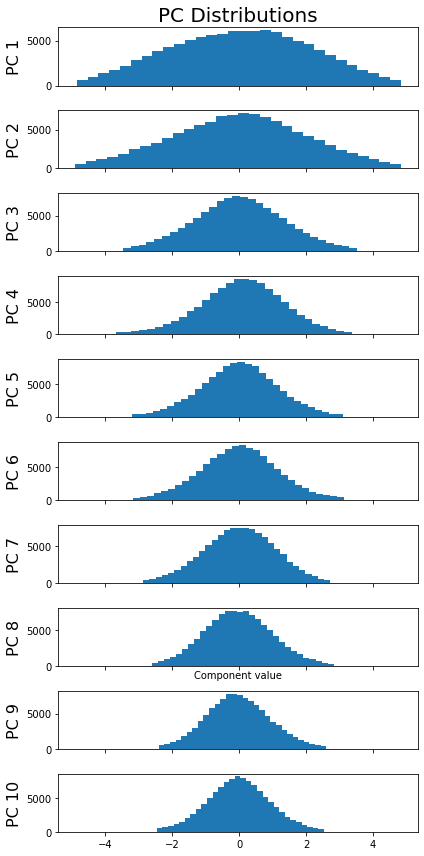

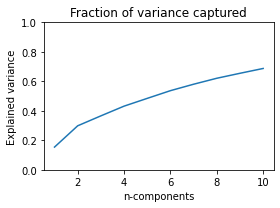

In [24]:
##################### PCA relevant figures #######################


########### plot distributions of PCs ###################
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 1, figsize=(6,12), sharex=True)
for i, ax in enumerate(axes[:]):
    ax.hist(df[pc_names].iloc[:,i].values, 30)
# for i, ax in enumerate(axes[:,1]):
#     ax.hist(nuc_weights[:,i], 30, (-2,2))
    
axes[0].set_title("PC Distributions", fontsize = 20)
# axes[0,1].set_title("Nucleus Distributions", fontsize = 20)
[ax.set_ylabel("PC %i"%(i+1), fontsize = 16) for i, ax in enumerate(axes[:])];
axes[7].set_xlabel("Component value")

plt.tight_layout()
plt.savefig(savedir+ 'PC distributions.png', bbox_inches='tight')



# How much variance is explained?
cell_variance = np.cumsum(pca.explained_variance_ratio_)
component_number = np.arange(len(cell_variance)) + 1

# Analysis of explained variance
df_dimred = {}
loading = pca.components_.T * np.sqrt(pca.explained_variance_)
for comp, pc_name in enumerate(pc_names):
    load = loading[:, comp]
    pc = [v for v in load]
    apc = [v for v in np.abs(load)]
    total = np.sum(apc)
    cpc = [100 * v / total for v in apc]
    df_dimred[pc_name] = pc
    df_dimred[pc_name.replace("_PC", "_aPC")] = apc
    df_dimred[pc_name.replace("_PC", "_cPC")] = cpc

# Store results as a dataframe
df_dimred["features"] = coeff_df.columns
df_dimred = pd.DataFrame(df_dimred)
df_dimred = df_dimred.set_index("features", drop=True)

# Plot variance
plt.figure(figsize=(4, 3))
plt.plot(component_number, cell_variance)
plt.ylim(0,1)
plt.xlabel("n-components")
plt.ylabel("Explained variance")
plt.title("Fraction of variance captured")

plt.tight_layout()
plt.savefig(savedir + 'Variance captured.png', bbox_inches='tight')



# ######## OR A DIFFERENT PLOT ##############
# # Make plot of explained variance
# plt.plot(100 * pca.explained_variance_ratio_[:npcs_to_calc], "-o")
# title = "Cum. variance: (1+2) = {0}%, Total = {1}%".format(
#     int(100 * pca.explained_variance_ratio_[:2].sum()),
#     int(100 * pca.explained_variance_ratio_[:].sum()),
# )
# plt.xlabel("Component", fontsize=18)
# plt.ylabel("Explained variance (%)", fontsize=18)
# plt.xticks(
#     ticks=np.arange(npcs_to_calc),
#     labels=np.arange(1, 1 + npcs_to_calc),
#     fontsize=14,
# )
# plt.yticks(fontsize=14)
# plt.title(title, fontsize=18)
# plt.tight_layout()



############## SEE WHICH FEATURES ARE MOST IMPORTANT IN EACH PC #############
save = savedir + 'Feature_Importance'
# Log feature importance along each PC
with open(f"{save}.txt", "w") as flog:

    for comp in range(npcs):

        print(
            f"\nExamplined variance by PC{comp+1} = {100*pca.explained_variance_ratio_[comp]:.1f}%",
            file=flog,
        )

        # Feature importance is reported in 3 ways:
        # _PC - raw loading
        # _aPC - absolute loading
        # _cPC - normalized cummulative loading
        pc_name = pc_names[comp]
        df_sorted = df_dimred.sort_values(
            by=[pc_name.replace("_PC", "_aPC")], ascending=False
        )
        pca_cum_contrib = np.cumsum(
            df_sorted[pc_name.replace("_PC", "_aPC")].values
            / df_sorted[pc_name.replace("_PC", "_aPC")].sum()
        )
        pca_cum_thresh = np.abs(pca_cum_contrib - 0.80).argmin()
        df_sorted = df_sorted.head(n=pca_cum_thresh + 1)

        print(
            df_sorted[
                [
                    pc_name,
                    pc_name.replace("_PC", "_aPC"),
                    pc_name.replace("_PC", "_cPC"),
                ]
            ].head(),
            file=flog,
        )

In [25]:
############# CALCULATE bins for CGPS ###################
    
nbins = 11


#remove the "Cell_" from PCs
for x in df.columns.to_list():
    if 'PC' in x:
        df = df.rename(columns = {x:x.replace('Cell_','')})


pclist = [x for x in df.columns.to_list() if 'PC' in x]
centers = []
for count, col in enumerate(pclist):
    df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
        df = df,
        feature = col,
        nbins = nbins,
        filter_based_on = pclist,
        filter_extremes_pct = 0,
        save = None,
        return_freqs_per_structs = False,
    )
    #put bin_indexes into a larger list that I can later iterate through
    df[f'PC{count+1}bins'] = df_digit.bin
    #get bin centers for each PC
    centers.append(pd.Series(bin_centers*pc_std, name=col))
centers = pd.DataFrame(centers).T
centers.to_csv(savedir+'PC_bin_centers.csv')

################ add all of the different classifiers to the dataset
treat = []
experiment = []
date = []
galv37Cdates = ['20231116', '20231122']

for f, m in zip(df['cell'].to_list(), df['frame'].to_list()):
    if 'CK666' in f:
        treat.append('CK666')
        experiment.append('Drug')
    elif 'ParaNitroBleb' in f:
        treat.append('Para-Nitro-Blebbistatin')
        experiment.append('Drug')
    elif 'DMSO' in f:
        treat.append('DMSO')
        experiment.append('Drug')
    elif any([x in f for x in galv37Cdates]):
        treat.append('Random')
        experiment.append('Galvanotaxis')
    else:
        print(f'Hey this one isnt captured: {f}')

            
    #get the date and experiment number on that date
    spl = f.split('_')
    date.append(spl[0])

df['Date'] = date
df['Treatment'] = treat
df['Experiment'] = experiment
            
            
df.to_csv(savedir + 'All_Data_with_CGPS_bins.csv')
print('Calculated combined PCs and binned PCs')

Calculated combined PCs and binned PCs
